# Vehicle Complaints NLP Analysis

## Policy Question

### What vehicle safety and service issues are most frequently raised by consumers, and how can text analysis of complaint narratives enhance early detection and inform smarter regulatory actions?

## Package Loading

In [2]:
import pandas as pd
import numpy as np
import re
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from spacy.matcher import PhraseMatcher
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud, STOPWORDS

## Dataset Breakdown

The dataset comes from the **NHTSA Office of Defects Investigation (ODI) - Complaints** database for automobiles. This database collects vehicle owner complaint information, which is used alongside other data sources to identify safety issues that warrant investigation and to monitor defect trends, including the scope and adequacy of existing recalls.

For this analysis, we filtered the dataset to include only complaint entries **from the year 2015 onward**, resulting in **872,933 complaint records**.

The cleaned dataset contains 25 columns, covering both structured and unstructured fields:

- **Unstructured Text Fields**:
  - `CDESCR`: Full complaint narrative provided by consumers.  
    → **Used as the primary source for text analysis** due to its detailed issue descriptions.
  - `COMPDESC`: Short component description.  
    → Present but **not used**, as `CDESCR` offers richer information.

- **Structured Data Fields**:
  - Examples of key structured columns:
    - `FAILDATE`: Date of incident (YYYYMMDD) → **Used for temporal trend analysis**.
    - `MFR_NAME`: Manufacturer’s name.
    - `MAKETXT`, `MODELTXT`, `YEARTXT`: Vehicle make, model, and year.
    - `CRASH`, `FIRE`, `INJURED`, `DEATHS`: Crash involvement, fire, injuries, fatalities.
    - `STATE`, `CITY`: Location information.
    - `CMPL_TYPE`: Source of the complaint (e.g., hotline, website).
    - `POLICE_RPT_YN`, `ORIG_OWNER_YN`, `ANTI_BRAKES_YN`, `CRUISE_CONT_YN`: Binary indicators of vehicle or incident features.
    - `PROD_TYPE`: Product type (vehicle, tires, equipment, child restraint).
    - `MEDICAL_ATTN`, `VEHICLES_TOWED_YN`: Medical attention required and towing status.

- **Documentation Reference**:  
  Detailed field definitions are available in the official NHTSA documentation:  
  [Import Instructions and Data Dictionary (PDF)](https://static.nhtsa.gov/odi/ffdd/cmpl/Import_Instructions_Excel_All.pdf)


## Basic Unstructured Data Analysis

### Step 1: Clean & Normalize the CDESCR Narratives

Transferred to `Spacy_Preprocessing.ipynb` to handle longer processing time.

### Step 2: Extract Named Entities and Key Terms

Transferred to `Spacy_Preprocessing.ipynb` to handle longer processing time.

### Step 3: Narrative Clustering (Updated with CHI evaluation)

In [ ]:
df = pd.read_parquet("complaints_with_entities.parquet")

100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


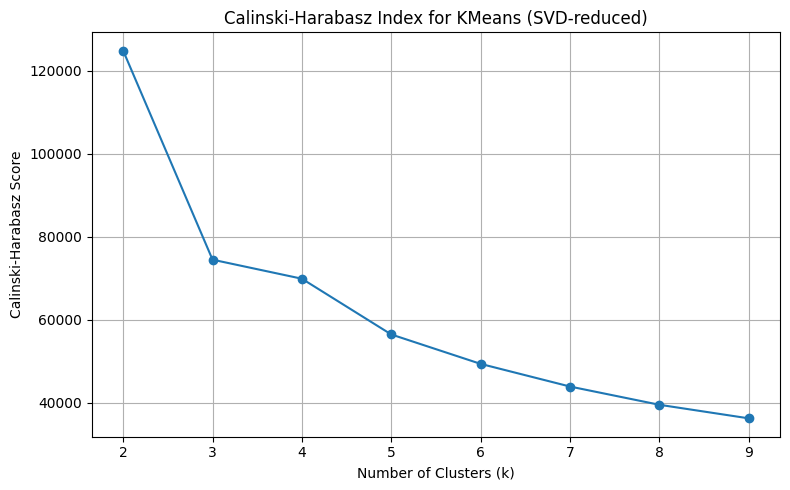

In [22]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=10)
X_tfidf = tfidf.fit_transform(df["cd_text"])

# Dimensionality reduction to speed up CHI computation
svd = TruncatedSVD(n_components=100, random_state=0)
X_reduced = svd.fit_transform(X_tfidf)

scores = []
k_values = range(2, 10)

for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_reduced)
    score = calinski_harabasz_score(X_reduced, labels)
    scores.append(score)

# Plot CHI scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Index for KMeans (SVD-reduced)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
kmeans = KMeans(n_clusters=4, random_state=0)
df['cluster'] = kmeans.fit_predict(X_tfidf)

In [24]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
sparse.save_npz("tfidf_matrix.npz", X_tfidf)
joblib.dump(kmeans, "kmeans_model.pkl")
df.to_parquet("complaints_with_clusters.parquet", index=False)

In [3]:
# Reload everything
tfidf = joblib.load("tfidf_vectorizer.pkl")
X_tfidf = sparse.load_npz("tfidf_matrix.npz")
kmeans = joblib.load("kmeans_model.pkl")
df = pd.read_parquet("complaints_with_clusters.parquet")

In [4]:
def get_top_terms_per_cluster(tfidf_matrix, kmeans_model, vectorizer, top_n=10, exclude_words=None):
    if exclude_words is None:
        exclude_words = set()

    centroids = kmeans_model.cluster_centers_
    terms = vectorizer.get_feature_names_out()
    top_terms = {}

    for i, centroid in enumerate(centroids):
        # Sort indices by descending weight
        sorted_indices = centroid.argsort()[::-1]
        filtered_terms = [
            terms[idx] for idx in sorted_indices
            if terms[idx] not in exclude_words
        ]
        # Take the top_n after filtering
        top_terms[i] = filtered_terms[:top_n]

    return top_terms

exclude_words = {"vehicle", "car"}
top_terms_per_cluster = get_top_terms_per_cluster(X_tfidf, kmeans, tfidf, top_n=10, exclude_words=exclude_words)

for cluster, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")



Cluster 0: start, engine, drive, light, turn, stop, time, come, problem, go
Cluster 1: recall, issue, door, airbag, problem, passenger, drive, light, engine, replace
Cluster 2: brake, steering, drive, power, light, turn, stop, truck, happen, control
Cluster 3: contact, failure, manufacturer, repair, state, own, mileage, tl, dealer, diagnose


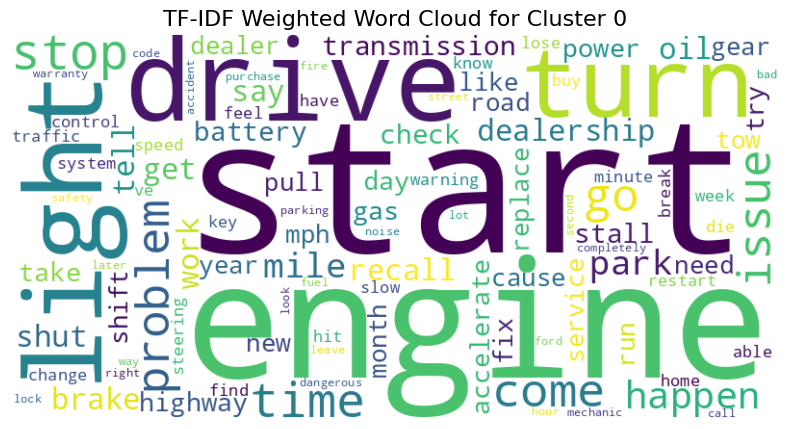

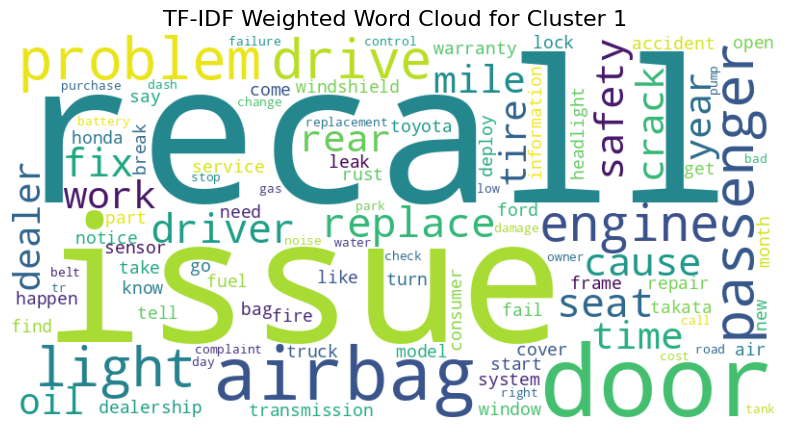

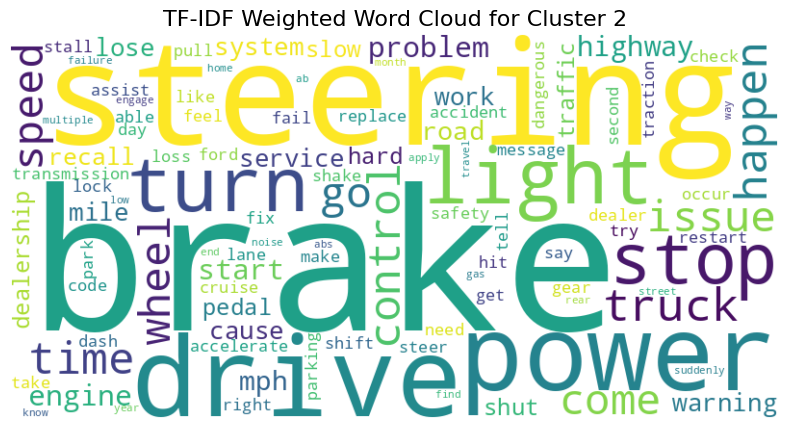

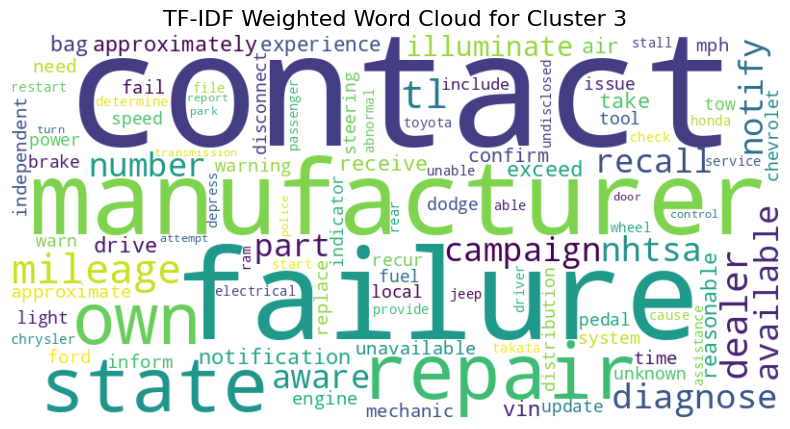

In [28]:
terms = tfidf.get_feature_names_out()
centroids = kmeans.cluster_centers_

# List of words you want to exclude
exclude_words = {"vehicle", "car"}

for cluster_num, centroid in enumerate(centroids):
    # Filter out the excluded words
    word_weights = {
        terms[i]: centroid[i]
        for i in range(len(terms))
        if centroid[i] > 0 and terms[i] not in exclude_words
    }

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'TF-IDF Weighted Word Cloud for Cluster {cluster_num}', fontsize=16)
    plt.show()

#### 🔎 Interpretation of Clusters (k = 4)

##### 🟦 Cluster 0 — **Performance**
- **Top words**: start, engine, drive, light, turn, stop, time, come, problem, go  
- **Interpretation**: Captures engine startup, driveability, and lighting problems — classic user-reported performance issues.

---

##### 🟥 Cluster 1 — **Recall & Safety**
- **Top words**: recall, issue, door, airbag, problem, passenger, drive, light, engine, replace  
- **Interpretation**: Strong presence of recall, airbags, and doors → represents regulatory/safety concerns.

---

##### 🟩 Cluster 2 — **Brakes & Steering**
- **Top words**: brake, steering, drive, power, light, turn, stop, truck, happen, control  
- **Interpretation**: Reflects braking and steering issues, which impact vehicle control and safety.

---

##### 🟨 Cluster 3 — **Repair & Manufacturer**
- **Top words**: contact, failure, manufacturer, repair, state, own, mileage, tl, dealer, diagnose  
- **Interpretation**: Focused on interactions with manufacturers, repair processes, ownership, and service experiences.


In [29]:
cluster_names = {
    0: "Performance",
    1: "Recall & Safety",
    2: "Brakes & Steering",
    3: "Repair & Manufacturer"
}

df["cluster_name"] = df["cluster"].map(cluster_names)
df.to_parquet("complaints_with_cluster_names.parquet", index=False)

### Step 4: Temporal Pattern Analysis (Clustering + Temporal Trend)


In [30]:

df = pd.read_parquet("complaints_with_cluster_names.parquet")

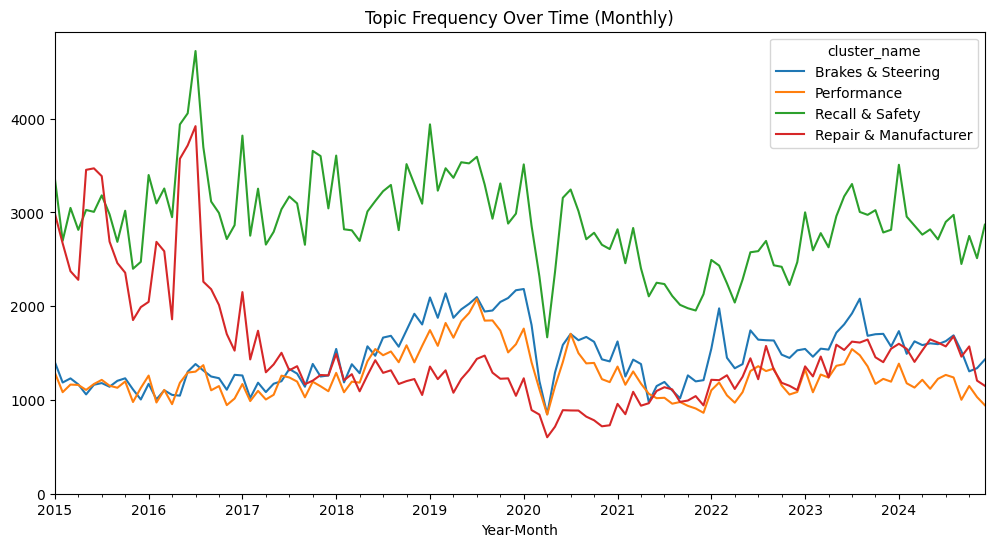

In [32]:
df["FAILDATE"] = pd.to_datetime(df["FAILDATE"], errors="coerce")
df["year_month"] = df["FAILDATE"].dt.to_period("M")  # Use period for proper grouping by month

df = df[df["year_month"] <= "2025-3"]  # Adjust filter if needed

topic_counts = df.groupby(["year_month", "cluster_name"]).size().unstack().fillna(0)

# Plot time series for selected clusters (now monthly)
ax = topic_counts.plot(kind="line", figsize=(12, 6), title="Topic Frequency Over Time (Monthly)")
ax.set_ylim(bottom=0)
ax.set_xlabel("Year-Month")
plt.show()

### **Key Findings**

- **Recall & Safety** dominates complaint volumes throughout the period, with a **major spike in 2016** likely tied to large-scale recall events.

- **Repair & Manufacturer** complaints also surged in **2016**, followed by a sharp decline but with **recurrent surges after 2021**, suggesting ongoing service or parts-related issues.

- **Brakes & Steering** shows **episodic peaks**, especially around **2019** and **post-2021**, indicating periods of elevated consumer concern.

- **Complaint volumes dropped sharply in early 2020**, likely due to pandemic-related disruptions in reporting and vehicle usage.

- **Short-term spikes across key clusters highlight the need for continuous monitoring** to catch emerging risks before they escalate.


### **Policy Recommendation**

- **NHTSA**: **Prioritize investigation** when complaint volumes in key clusters **rise significantly above baseline patterns over consecutive months**; cross-reference spikes with ongoing or pending recall campaigns.

- **Consumer Watchdog Groups**: **Amplify public messaging** and **encourage timely complaint reporting** when safety or performance-related concerns **exhibit upward trends**.


### Step 5: Brand-Level Complaint Distribution Across Clusters (ENR + Clustering)


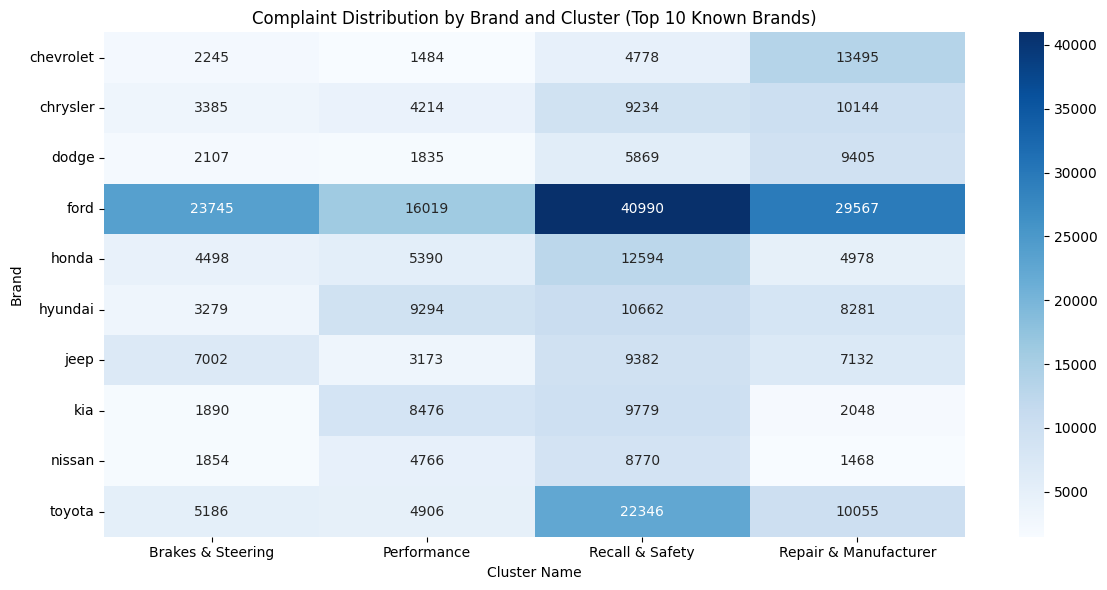

In [37]:
cluster_names = {
    0: "Performance",
    1: "Recall & Safety",
    2: "Brakes & Steering",
    3: "Repair & Manufacturer"
}

known_brands = [
    "ford", "toyota", "chevrolet", "honda", "hyundai", "kia",
    "nissan", "jeep", "subaru", "volkswagen", "gmc", "ram", "dodge",
    "bmw", "mercedes", "tesla", "cadillac", "chrysler", "mazda", 'volkswagen'
]

df_entities = df[["cluster", "entities"]].explode("entities")
df_entities["cluster name"] = df_entities["cluster"].map(cluster_names)
brand_clusters = df_entities[df_entities["entities"].isin(known_brands)]
brand_counts = brand_clusters["entities"].value_counts()
top_brands = brand_counts.head(10).index.tolist()
top_brand_clusters = brand_clusters[brand_clusters["entities"].isin(top_brands)]
brand_cluster_counts = (
    top_brand_clusters.groupby(["entities", "cluster name"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(brand_cluster_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Complaint Distribution by Brand and Cluster (Top 10 Known Brands)")
plt.xlabel("Cluster Name")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()


### **Key Findings**

- **Ford** consistently **dominates** complaint mentions across all clusters, with especially high volumes in **Recall & Safety** and **Brakes & Steering**.
- **Chevrolet** shows an unusually high number of **Repair & Manufacturer** complaints **relative to its lower counts** in other categories, suggesting a potential service-related issue.
- **Toyota** exhibits a significant concentration of complaints in **Brakes & Steering** and also ranks high in **Recall & Safety**, indicating sustained consumer concern in these areas.



### **Policy Recommendation**

- **NHTSA**: **Closely monitor** **Recall & Safety** and **Brakes & Steering** complaints for **Ford** as potential early indicators of **systemic issues**.
- **Consumer Protection Agencies**: **Scrutinize** the high **Repair & Manufacturer** complaints for **Chevrolet** to ensure consumers are informed of their **service and warranty rights**.
- **Automakers (Toyota & Ford)**: **Review and address recurring concerns** in **Brakes & Steering** (**Toyota**) and **Safety** (**Ford**) to **prevent escalation** and enhance **consumer trust**.

## Conclusion

This analysis leveraged clustering and entity recognition on over 870,000 vehicle complaint narratives from the NHTSA Office of Defects Investigation (ODI) to identify key safety and service issues reported by consumers since 2015. Through unsupervised text analysis, we uncovered meaningful patterns that can support earlier detection of risks and more informed regulatory decision-making.

### **Insights Addressing the Policy Question**

- **Recall & Safety issues remain the dominant concern across consumer complaints**, with identifiable spikes—particularly the significant surge in 2016—likely tied to large-scale recall campaigns such as airbag recalls. These patterns highlight the effectiveness of complaints data as an early-warning signal for systemic safety defects.

- **Service-related issues, captured by the Repair & Manufacturer cluster, show recurrent surges after 2021**, suggesting persistent challenges in repair processes, parts availability, or customer service experiences that may warrant closer oversight.

- **Braking and Steering problems display episodic peaks across the timeline**, reinforcing the importance of monitoring critical control systems that directly affect vehicle safety.

- **Brand-level analysis reveals that Ford consistently appears across high-volume complaint categories**, particularly in Recall & Safety and Brakes & Steering, suggesting the need for continued scrutiny of its product lines. **Chevrolet’s elevated Repair & Manufacturer complaints** also point to potential service delivery issues, while **Toyota’s concentration in Brakes & Steering** signals sustained consumer concern in this critical area.

- **Pandemic-related disruptions are observable in a sharp drop in complaint volumes in early 2020**, underscoring how external factors can influence reporting behavior and the need for adaptive monitoring strategies.

### **Policy Implications**

- **Complaint data analysis provides a scalable, low-cost supplement to traditional investigation mechanisms** by surfacing emerging patterns before formal recall actions are initiated.

- **Regulators and consumer watchdog groups can leverage these insights to prioritize investigations and amplify public awareness** when abnormal complaint trends are detected, particularly in high-risk categories like safety equipment and braking systems.

- **Manufacturers can use these findings to proactively address known issue areas, improve service processes, and enhance consumer trust**, reducing the likelihood of regulatory intervention and reputational damage.

By systematically analyzing unstructured consumer feedback, this approach offers a data-driven foundation for smarter regulatory actions and more responsive safety monitoring.
